# Final Exam - Who is likely to commit fraud?

- July 3, 2020

In [1]:
#import sys
#!conda install --yes -c conda-forge category_encoders

In [35]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -- sklearn modules 
from sklearn.model_selection import train_test_split   #- partition train/test split 
from sklearn.tree import DecisionTreeClassifier        #- create a decison tree 
from sklearn.ensemble import ExtraTreesClassifier      #- random trees 
from sklearn.ensemble import RandomForestClassifier    #- random forest classifier 
from sklearn.ensemble import GradientBoostingClassifier #- GBM classfier 

# -- to make pipeline 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV

# -- categorical encoders
#import category_encoders as ce


# -- render charts in notebook 
%matplotlib inline


## Stage

In [38]:
#df1 = pd.read_csv('phones.csv').rename(columns={"product_id":"phone_id"})

phones = pd.read_csv('./data/phones.csv').rename(columns={"product_id":"phone_id"})
phones.head()

,phone_id,product_name,product_mfg
0,0,"Samsung Galaxy S9, 64GB, Lilac Purple - Fully ...",Samsung
1,1,Samsung Galaxy A71 SM-A715F/DS 4G LTE 128GB + ...,Samsung
2,2,"Apple iPhone 8 Plus, GSM Unlocked, 64GB - Spac...",Apple
3,3,"Motorola Moto G7 (64GB, 4GB RAM) Dual SIM 6.2""...",Motorola
4,4,OnePlus 8 Pro Ultramarine Blue 12GB+256GB with...,OnePlus


In [39]:
#df2 = pd.read_csv('new_subscribers.csv')
txn = pd.read_csv('./data/new_subscribers.csv')
txn.head()

,total_lifetime_value,credit_score,shipping_amt,promo_discount,ip_address,avs_code,email_domain,user_agent,billing_postal,phone_id,...,phone_plan,accessory_count,event_timestamp,transaction_id,customer_name,billing_address,billing_state,email_name,phone_number,is_fraud
0,5899.00000,647.00000,71.00000,267.00000,6.58.107.44,Q,harrington-barrett.com,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,34630.00000,130.00000,...,Just Kids,4.00000,2020-04-28 02:58:00,9379067230.00000,Stephanie Fletcher,89142 Smith Light Fake St.,VA,haley41,(220)631-5381,0
1,4882.00000,582.00000,72.00000,154.00000,50.60.19.244,A,juarez-howard.com,Mozilla/5.0 (iPad; CPU iPad OS 4_2_1 like Mac ...,34293.00000,140.00000,...,Do More Unlimited,4.00000,2020-05-08 17:54:53,4271059298.00000,Rita Conley,8045 Taylor Camp Fake St.,UT,jennifergarcia,+1-636-156-6620x3320,0
2,4871.00000,624.00000,55.00000,253.00000,195.253.71.163,C,butler.net,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_5_6) A...,32424.00000,241.00000,...,Just Kids,6.00000,2020-01-01 21:34:21,2856708112.00000,Sophia Goodman,27185 Santos Common Fake St.,CO,edward79,+1-254-407-6887x778,0
3,6404.00000,599.00000,63.00000,258.00000,89.103.126.109,F,casey-thomas.com,Mozilla/5.0 (Windows; U; Windows NT 5.1) Apple...,32457.00000,132.00000,...,Just Kids,6.00000,2019-12-13 07:21:42,5797871695.00000,Linda Ray,35490 Xavier Knolls Fake St.,ID,derekramirez,001-651-607-4678x1641,0
4,4530.00000,572.00000,56.00000,251.00000,45.247.92.14,F,meyer-flores.com,Mozilla/5.0 (iPod; U; CPU iPhone OS 4_3 like M...,32453.00000,211.00000,...,Just Kids,4.00000,2019-10-11 18:54:24,9983474236.00000,Angela Davis,9478 Byrd Shore Fake St.,IN,rperez,4748914665,0


In [40]:
df = pd.merge(txn, phones, on='phone_id', how='inner')
df.head()

,total_lifetime_value,credit_score,shipping_amt,promo_discount,ip_address,avs_code,email_domain,user_agent,billing_postal,phone_id,...,event_timestamp,transaction_id,customer_name,billing_address,billing_state,email_name,phone_number,is_fraud,product_name,product_mfg
0,5899.00000,647.00000,71.00000,267.00000,6.58.107.44,Q,harrington-barrett.com,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,34630.00000,130.00000,...,2020-04-28 02:58:00,9379067230.00000,Stephanie Fletcher,89142 Smith Light Fake St.,VA,haley41,(220)631-5381,0,Samsung Galaxy S9 G960U 64GB Unlocked [Midnigh...,Samsung
1,6171.00000,696.00000,73.00000,236.00000,220.36.198.170,F,weaver-deleon.com,Opera/8.10.(X11; Linux i686; hy-AM) Presto/2.9...,33719.00000,130.00000,...,2019-12-23 02:57:19,3202836915.00000,Albert Merritt,02183 Evelyn Drive Fake St.,NE,cameron24,959.599.8446x6638,0,Samsung Galaxy S9 G960U 64GB Unlocked [Midnigh...,Samsung
2,6882.00000,618.00000,60.00000,274.00000,58.222.104.72,U,ponce.info,Opera/9.32.(Windows NT 4.0; ja-JP) Presto/2.9....,32843.00000,130.00000,...,2020-02-26 14:31:06,6407146896.00000,Collin Brady,758 Wells Drive Fake St.,WY,nicolehernandez,+1-791-398-1973,0,Samsung Galaxy S9 G960U 64GB Unlocked [Midnigh...,Samsung
3,5900.00000,637.00000,66.00000,224.00000,150.163.66.23,R,gibbs.net,Mozilla/5.0 (compatible; MSIE 6.0; Windows NT ...,32433.00000,130.00000,...,2020-03-28 06:32:02,4414650025.00000,Rebekah Williamson,726 Cummings Drives Fake St.,KY,jessicaroth,413-812-2126x11134,0,Samsung Galaxy S9 G960U 64GB Unlocked [Midnigh...,Samsung
4,6950.00000,584.00000,68.00000,179.00000,7.59.143.109,A,fitzgerald-smith.info,Opera/9.97.(X11; Linux x86_64; so-SO) Presto/2...,33641.00000,130.00000,...,2020-06-23 06:20:00,6104239232.00000,Charlene English,15064 Tracy Divide Fake St.,FL,gary31,+1-872-862-6274x82314,0,Samsung Galaxy S9 G960U 64GB Unlocked [Midnigh...,Samsung


In [41]:
# -- so i don't think you need to sample... your code looks great! 
# df = df.sample(25000)
df.shape

(99953, 26)

## Clean up column names

In [42]:
df.columns = ( df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace('-', '_')
    .str.replace('(', '')
    .str.replace(')', '')
    .str.replace('?', '')
    .str.replace('\'', '') # notice the backslash \ this is an escape character
    .str.replace('.', '_')          
)
print(df.columns)

Index(['total_lifetime_value', 'credit_score', 'shipping_amt',
       'promo_discount', 'ip_address', 'avs_code', 'email_domain',
       'user_agent', 'billing_postal', 'phone_id', 'phone_count',
       'phone_trade_in', 'phone_protection', 'contract_term', 'phone_plan',
       'accessory_count', 'event_timestamp', 'transaction_id', 'customer_name',
       'billing_address', 'billing_state', 'email_name', 'phone_number',
       'is_fraud', 'product_name', 'product_mfg'],
      dtype='object')


In [8]:
def df_profile(df, target):
    
    df = df.copy()
    
    numeric_features = [ c for c in df.select_dtypes(include = np.number).columns ]
    pd.options.display.float_format = '{:.5f}'.format
    
    categorical_features = [ c for c in df.select_dtypes(include = np.object).columns ]
   
    rowcnt = len(df)
    df_s1  = df.agg(['count', 'nunique','mean','min','max']).transpose().reset_index().rename(columns={"index":"feature_name"}).round(4)
    df_s1['count'] = df_s1['count'].astype('int64')
    df_s1['nunique'] = df_s1['nunique'].astype('int64')
    df_s1["null"] = (rowcnt - df_s1["count"]).astype('int64')
    df_s1["not_null"] = rowcnt - df_s1["null"]
    df_s1["null_pct"] = df_s1["null"] / rowcnt
    df_s1["nunique_pct"] = df_s1['nunique'] / rowcnt

    
    dt = pd.DataFrame(df.dtypes).reset_index().rename(columns={"index":"feature_name", 0:"dtype"})
    df_stats = pd.merge(dt, df_s1, on='feature_name', how='inner')

    df_stats = df_stats.sort_values("dtype").reset_index(drop=True)
    
    df_stats['feature_type'] = "UNKNOWN"
    df_stats.loc[np.logical_or(df_stats['dtype'] == int, df_stats['dtype'] == float), 'feature_type'] = "NUMERIC"
    df_stats.loc[df_stats['dtype'] == object, 'feature_type'] = "CATEGORY"
    df_stats.loc[df_stats['feature_name'] == target, 'feature_type'] = "TARGET"
    
    df_stats['feature_warning'] = "NO WARNING"
    df_stats.loc[df_stats['nunique_pct'] > 0.9, 'feature_warning'] = "EXCLUDE, GT 90% UNIQUE"
    df_stats.loc[df_stats['null_pct'] > 0.2, 'feature_warning'] = "NULL WARNING, GT 20% MISSING"
    df_stats.loc[df_stats['null_pct'] > 0.5, 'feature_warning'] = "EXCLUDE, GT 50% MISSING"
    df_stats.loc[np.logical_and(np.logical_or(df_stats['dtype'] == int, df_stats['dtype'] == float), df_stats['nunique'] <= 20), 'feature_warning'] = "LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"
   
    return df_stats

df_profile(df, 'is_fraud')

,feature_name,dtype,count,nunique,mean,min,max,null,not_null,null_pct,nunique_pct,feature_type,feature_warning
0,is_fraud,int64,100000,2,0.05280,0.00000,1.00000,0,100000,0.00000,0.00002,TARGET,"LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"
1,total_lifetime_value,float64,99961,5715,5035.44700,1000.00000,9999.00000,39,99961,0.00039,0.05715,NUMERIC,NO WARNING
2,credit_score,float64,99950,360,593.54880,400.00000,799.00000,50,99950,0.00050,0.00360,NUMERIC,NO WARNING
3,shipping_amt,float64,99956,86,56.60680,10.00000,99.00000,44,99956,0.00044,0.00086,NUMERIC,NO WARNING
4,promo_discount,float64,99953,384,261.97870,50.00000,499.00000,47,99953,0.00047,0.00384,NUMERIC,NO WARNING
5,billing_postal,float64,99954,2002,33454.74990,32005.00000,34996.00000,46,99954,0.00046,0.02002,NUMERIC,NO WARNING
6,phone_id,float64,99954,273,166.99210,1.00000,305.00000,46,99954,0.00046,0.00273,NUMERIC,NO WARNING
7,phone_count,float64,99954,5,3.35780,1.00000,5.00000,46,99954,0.00046,0.00005,NUMERIC,"LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"
8,transaction_id,float64,99954,99954,5504099758.92590,1000054664.00000,9999989262.00000,46,99954,0.00046,0.99954,NUMERIC,"EXCLUDE, GT 90% UNIQUE"
9,accessory_count,float64,99967,10,5.11300,1.00000,10.00000,33,99967,0.00033,0.00010,NUMERIC,"LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"


## Describe data

In [43]:
df['is_fraud'].value_counts()

0    94677
1     5276
Name: is_fraud, dtype: int64

In [44]:
df['is_fraud'].value_counts(normalize=True)

0   0.94722
1   0.05278
Name: is_fraud, dtype: float64

In [45]:
df.describe(include='all').T.sort_values('unique')
df.dtypes

total_lifetime_value    float64
credit_score            float64
shipping_amt            float64
promo_discount          float64
ip_address               object
avs_code                 object
email_domain             object
user_agent               object
billing_postal          float64
phone_id                float64
phone_count             float64
phone_trade_in           object
phone_protection         object
contract_term            object
phone_plan               object
accessory_count         float64
event_timestamp          object
transaction_id          float64
customer_name            object
billing_address          object
billing_state            object
email_name               object
phone_number             object
is_fraud                  int64
product_name             object
product_mfg              object
dtype: object

In [46]:
df.isnull().sum(axis = 0)

total_lifetime_value    39
credit_score            50
shipping_amt            44
promo_discount          47
ip_address              45
avs_code                41
email_domain            49
user_agent              51
billing_postal          46
phone_id                 0
phone_count             46
phone_trade_in          48
phone_protection        38
contract_term           31
phone_plan              39
accessory_count         33
event_timestamp         44
transaction_id          46
customer_name           40
billing_address         39
billing_state           62
email_name              36
phone_number            40
is_fraud                 0
product_name             0
product_mfg              0
dtype: int64

## Explore likely predictors

### Character column crosstabs

In [13]:
#- crosstab 1a
ctab = pd.crosstab(df['phone_plan'], df['is_fraud']).reset_index()
ctab.head()

is_fraud,phone_plan,0,1
0,Do More Unlimited,29564,1721
1,Get More Unlimited,361,33
2,Just Kids,48120,2597
3,Play More Unlimited,15439,869
4,Start Unlimited,1199,58


In [14]:
#- crosstab 1b with percentages
ctab = pd.crosstab(df['phone_plan'], df['is_fraud'], normalize="index").reset_index().sort_values(1, ascending=False )
ctab.head()

is_fraud,phone_plan,0,1
1,Get More Unlimited,0.91624,0.08376
0,Do More Unlimited,0.94499,0.05501
3,Play More Unlimited,0.94671,0.05329
2,Just Kids,0.94879,0.05121
4,Start Unlimited,0.95386,0.04614


In [15]:
#- crosstab 2a
ctab = pd.crosstab(df['phone_trade_in'], df['is_fraud']).reset_index()
ctab.head()

is_fraud,phone_trade_in,0,1
0,No,51905,2810
1,Yes,42771,2466


In [16]:
#- crosstab 2b with percentages
ctab = pd.crosstab(df['phone_trade_in'], df['is_fraud'], normalize="index").reset_index().sort_values(1, ascending=False )
ctab.head()

is_fraud,phone_trade_in,0,1
1,Yes,0.94549,0.05451
0,No,0.94864,0.05136


In [17]:
#- crosstab 3a
ctab = pd.crosstab(df['billing_state'], df['is_fraud']).reset_index()
ctab.head()

is_fraud,billing_state,0,1
0,AK,1786,106
1,AL,1871,107
2,AR,1839,127
3,AZ,1836,82
4,CA,1877,96


In [18]:
#- crosstab 3b with percentages
ctab = pd.crosstab(df['billing_state'], df['is_fraud'], normalize="index").reset_index().sort_values(1, ascending=False )
ctab.head()

is_fraud,billing_state,0,1
10,GA,0.93387,0.06613
2,AR,0.93540,0.06460
43,TX,0.93836,0.06164
26,MT,0.93857,0.06143
6,CT,0.93910,0.06090


In [19]:
#- crosstab 4a
ctab = pd.crosstab(df['contract_term'], df['is_fraud']).reset_index()
ctab.head()

is_fraud,contract_term,0,1
0,12mo,932,74
1,18mo,30069,1717
2,24mo,48599,2556
3,30mo,291,29
4,36mo,14799,903


In [20]:
#- crosstab 4b with percentages
ctab = pd.crosstab(df['contract_term'], df['is_fraud'], normalize="index").reset_index().sort_values(1, ascending=False )
ctab.head()

is_fraud,contract_term,0,1
3,30mo,0.90938,0.09062
0,12mo,0.92644,0.07356
4,36mo,0.94249,0.05751
1,18mo,0.94598,0.05402
2,24mo,0.95003,0.04997


### Numeric column scatterplots

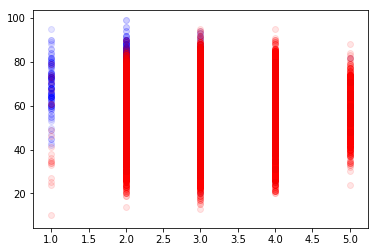

In [21]:
## Scatterplot 1 for phone_count and shipping_amt
df_yes = df[df['is_fraud'] == 1]
df_no = df[df['is_fraud'] == 0]

plt.scatter(df_yes['phone_count'], df_yes['shipping_amt'], c="blue", alpha = 0.1)
plt.scatter(df_no['phone_count'], df_no['shipping_amt'],  c="red", alpha = 0.1)
plt.show()

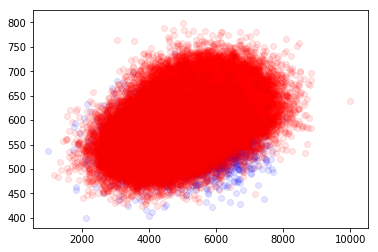

In [22]:
## Scatterplot 2 for total_lifetime_value
df_yes = df[df['is_fraud'] == 1]
df_no = df[df['is_fraud'] == 0]

plt.scatter(df_yes['total_lifetime_value'], df_yes['credit_score'], c="blue", alpha = 0.1)
plt.scatter(df_no['total_lifetime_value'], df_no['credit_score'],  c="red", alpha = 0.1)
plt.show()

### Seaborn's pairs plot

In [23]:
#sns.pairplot(df)

## Partition into 70/30 split

In [47]:
train, test = train_test_split(df,test_size=0.30)
print("train pct: {:2.2%}".format(train.shape[0]/df.shape[0]))
print("test  pct: {:2.2%}".format(test.shape[0]/df.shape[0]))

train pct: 70.00%
test  pct: 30.00%


## Create pipelines

In [49]:
## Split features into categorical and numeric 

excludes = ['email_name', 'phone_number','event_timestamp', 'customer_name', 'transaction_id', 'ip_address', 'user_agent', 'email_domain']

target = 'is_fraud'

numeric_features = [x for x in df.select_dtypes(include=['float64', 'int64']).columns if x not in [target] + excludes ]
print("-- numeric features --")
print(numeric_features)
print("")
categorical_features = [x for x in df.select_dtypes(include=['object']).columns if x not in [target] + excludes] 
print("-- categorical features --")
print(categorical_features)

-- numeric features --
['total_lifetime_value', 'credit_score', 'shipping_amt', 'promo_discount', 'billing_postal', 'phone_id', 'phone_count', 'accessory_count']

-- categorical features --
['avs_code', 'phone_trade_in', 'phone_protection', 'contract_term', 'phone_plan', 'billing_address', 'billing_state', 'product_name', 'product_mfg']


In [26]:
## fill in missing values
#df.isnull().sum(axis = 0)
#df[numeric_features]     = df[numeric_features].fillna(-1)
#df[categorical_features] = df[categorical_features].astype('str').fillna('missing')
df.isnull().sum(axis = 0)

total_lifetime_value    39
credit_score            50
shipping_amt            44
promo_discount          47
ip_address              45
avs_code                41
email_domain            49
user_agent              51
billing_postal          46
phone_id                46
phone_count             46
phone_trade_in          48
phone_protection        38
contract_term           31
phone_plan              39
accessory_count         33
event_timestamp         44
transaction_id          46
customer_name           40
billing_address         39
billing_state           62
email_name              36
phone_number            40
is_fraud                 0
product_name            47
product_mfg             47
dtype: int64

In [27]:
## Pipeline 1: DecisionTree - OneHotEncoder

categorical_pipe1 = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(transformers=[
    ('cat', categorical_pipe1, categorical_features),
    ('num', numerical_pipe, numeric_features)
    ])

decision_tree = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', DecisionTreeClassifier(max_depth = 10,
                                          min_samples_leaf = 2, 
                                          criterion = 'gini',
                                          random_state=42))
])

decision_tree.fit(train[categorical_features + numeric_features], train[target])

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                        

In [28]:
## Pipeline 2: RandomForest - OneHotEncoder

categorical_pipe2 = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(transformers=[
    ('cat', categorical_pipe2, categorical_features),
    ('num', numerical_pipe, numeric_features)
    ])

random_forest_pipe = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(n_estimators=100, 
                                          max_depth = 20,
                                          min_samples_leaf = 2,
                                           n_jobs=-1))
])

random_forest = random_forest_pipe.fit(train[categorical_features + numeric_features], train[target])
random_forest

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                        

In [29]:
## Pipeline 3: ExtraTrees - OneHotEncoder

categorical_pipe3 = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore')) 
])

numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(transformers=[
    ('cat', categorical_pipe3, categorical_features),
    ('num', numerical_pipe, numeric_features)
    ])

extra_trees = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', ExtraTreesClassifier( n_estimators=100, 
                                          max_depth = 20,
                                          min_samples_leaf = 2,
                                           n_jobs=-1))
])

extra_trees = extra_trees.fit(train[categorical_features + numeric_features], train[target])
extra_trees

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                        

## Evaluate

### Variable importance

In [30]:
def model_var_importance(model, model_name):
    
    importance =  model.named_steps["classifier"].feature_importances_
    # -- gets the feature names
    categorical_pipe1.fit_transform(train[categorical_features])
    transformed_categorical = categorical_pipe1['onehot'].get_feature_names(categorical_features).tolist()

    # -- creates one list of all the feature names.
    feature_names =  transformed_categorical + numeric_features

    # -- summarize feature importance into a dictionary 
    feature_imp ={}
    for i,v in enumerate(importance):
        items = feature_names[i].split('_')
        if items[0].isdigit():
            fname = categorical_features[int(items[0])] + "_" + items[1]
            feature_imp[fname] = v
        else:
            feature_imp[feature_names[i]] = v
            #print(items[0].isdigit())
            #print(items)
        #if int(items[0]) >= 0:  
        #print(categorical_features[int(items[0])])

    # make the dictionary a data frame 
    feature_imp = pd.DataFrame.from_dict(feature_imp, orient='index',
                                         columns=['importance'])

    # -- prep and filter our dataframe, only need to look at the important features i.e. things > 0 
    feature_imp = (feature_imp
                   .reset_index()
                   .rename(columns={'index':'feature'})
                   .sort_values('importance',ascending=False)
                   .query('importance > 0.01'))

    # -- plot that 
    plt.figure(figsize=(10,10))
    sns.barplot(x="importance", y="feature", data=feature_imp, color="lightblue")
    plt.title( model_name + 'Variable Importance')
    plt.ylabel('Feature')
    plt.xlabel('Importance')
    plt.xticks(rotation=45)
    plt.show()

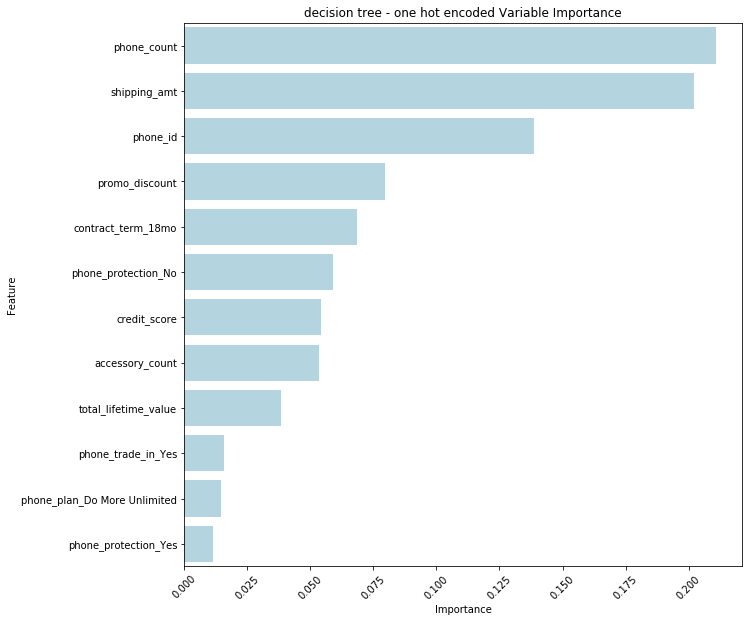

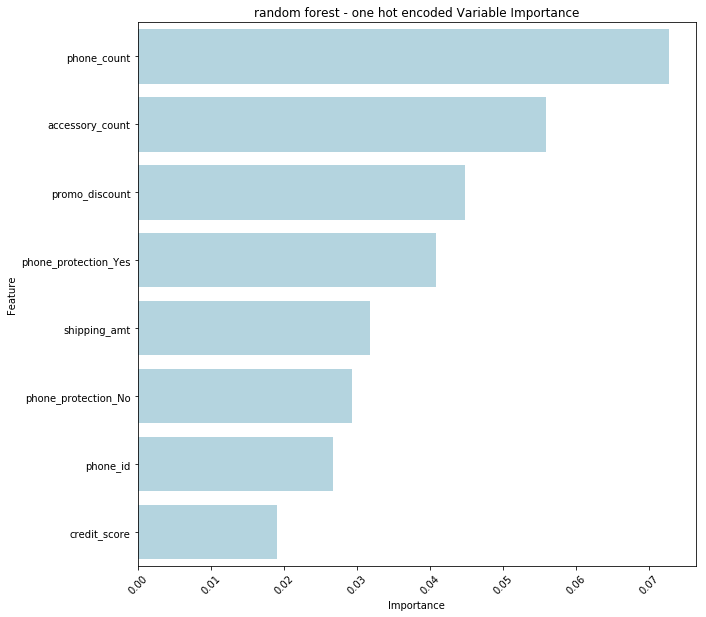

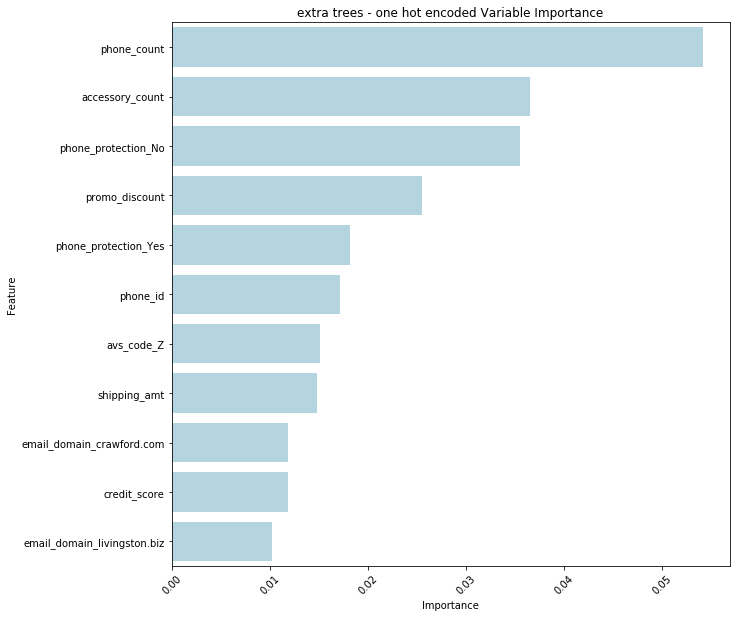

In [31]:
model_var_importance(decision_tree, "decision tree - one hot encoded ")
model_var_importance(random_forest, "random forest - one hot encoded ")
model_var_importance(extra_trees, "extra trees - one hot encoded ")

### Confusion matrix

decision tree - Training Confusion Matrix
decision tree - Testing Confusion Matrix


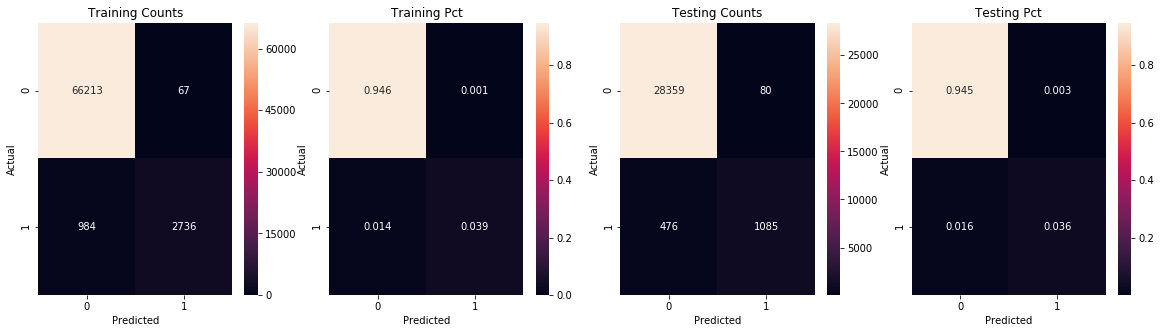

random forest - Training Confusion Matrix
random forest - Testing Confusion Matrix


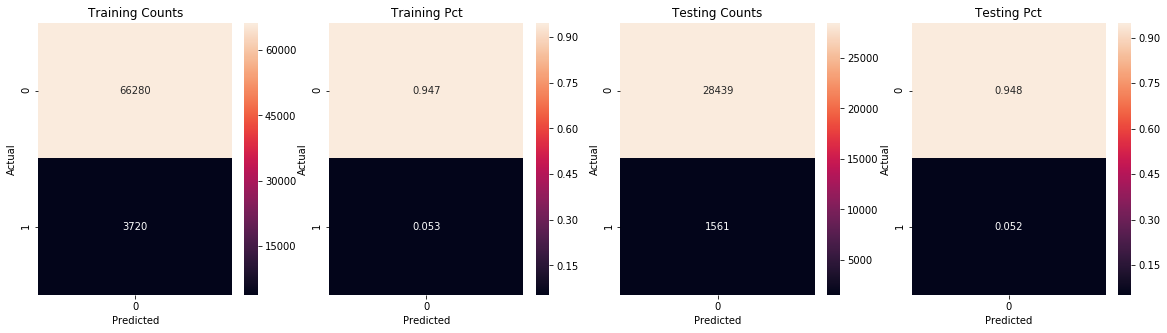

extra trees - Training Confusion Matrix
extra trees - Testing Confusion Matrix


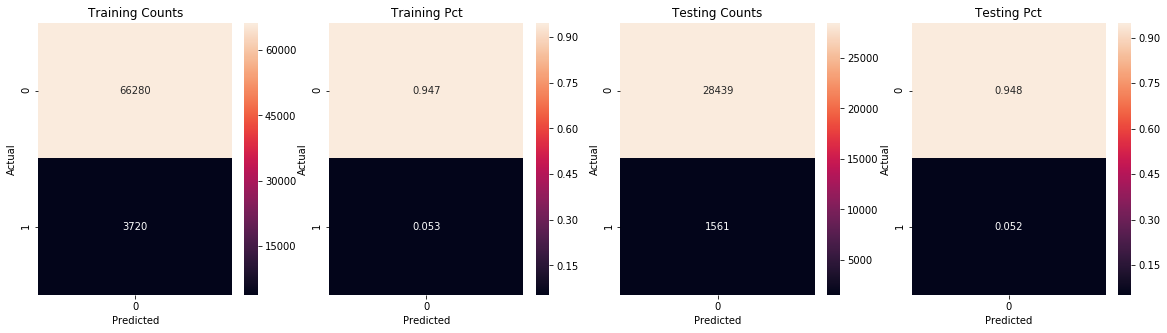

In [32]:
def model_confusion_matrix(model, model_name):
    train['is_fraud_pred'] = model.predict(train[numeric_features + categorical_features])
    test['is_fraud_pred'] = model.predict(test[numeric_features + categorical_features])
     
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
    
    print(model_name + " - Training Confusion Matrix")
    confusion_matrix = pd.crosstab(train['is_fraud'], train['is_fraud_pred'],  rownames=['Actual'], colnames=['Predicted'])
    confusion_matrix_pct = pd.crosstab(train['is_fraud'], train['is_fraud_pred'], normalize="all", rownames=['Actual'], colnames=['Predicted']).round(3)
    sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax1)
    sns.heatmap(confusion_matrix_pct, annot=True, fmt='g', ax=ax2)
    
    print(model_name + " - Testing Confusion Matrix")
    confusion_matrix = pd.crosstab(test['is_fraud'], test['is_fraud_pred'],  rownames=['Actual'], colnames=['Predicted'])
    confusion_matrix_pct = pd.crosstab(test['is_fraud'], test['is_fraud_pred'], normalize="all", rownames=['Actual'], colnames=['Predicted']).round(3)


    sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax3)
    sns.heatmap(confusion_matrix_pct, annot=True, fmt='g', ax=ax4)
    
    ax1.title.set_text('Training Counts')
    ax2.title.set_text('Training Pct')
    ax3.title.set_text('Testing Counts')
    ax4.title.set_text('Testing Pct')
    
    plt.show()
    
    
model_confusion_matrix(decision_tree, "decision tree")
model_confusion_matrix(random_forest, "random forest")
model_confusion_matrix(extra_trees, "extra trees")

### Accuracy score

In [33]:
from sklearn.metrics import accuracy_score

def model_accuracy(model, model_name):
    test['is_fraud_pred'] = model.predict(test[numeric_features + categorical_features])
    accuracy_default = train['is_fraud'].value_counts(normalize='True')[0]
    accuracy_train = accuracy_score(train['is_fraud'], train['is_fraud_pred'])
    accuracy_test = accuracy_score(test['is_fraud'], test['is_fraud_pred'])
    print("--" + model_name + " model accuracy report --")
    print("Default Accuracy : {:2.2%}".format(accuracy_default))
    print("Train Accuracy   : {:2.2%}".format(accuracy_train))
    print("Test Accuracy    : {:2.2%}".format(accuracy_test))
    print("\n")
    
    
    
model_accuracy(decision_tree, "decision tree")
model_accuracy(random_forest, "random forest")
model_accuracy(extra_trees, "extra trees")

--decision tree model accuracy report --
Default Accuracy : 94.69%
Train Accuracy   : 94.69%
Test Accuracy    : 98.15%


--random forest model accuracy report --
Default Accuracy : 94.69%
Train Accuracy   : 94.69%
Test Accuracy    : 94.80%


--extra trees model accuracy report --
Default Accuracy : 94.69%
Train Accuracy   : 94.69%
Test Accuracy    : 94.80%




### AUC and ROC

--- decision tree ---
Train AUC Score        : 0.955120
Test AUC Score         : 0.928290


--- TEST score thresholds ---
      fpr     tpr  threshold
0 0.01000 0.72000    0.47000
1 0.02000 0.78000    0.19000
2 0.03000 0.82000    0.10000
3 0.04000 0.85000    0.05000




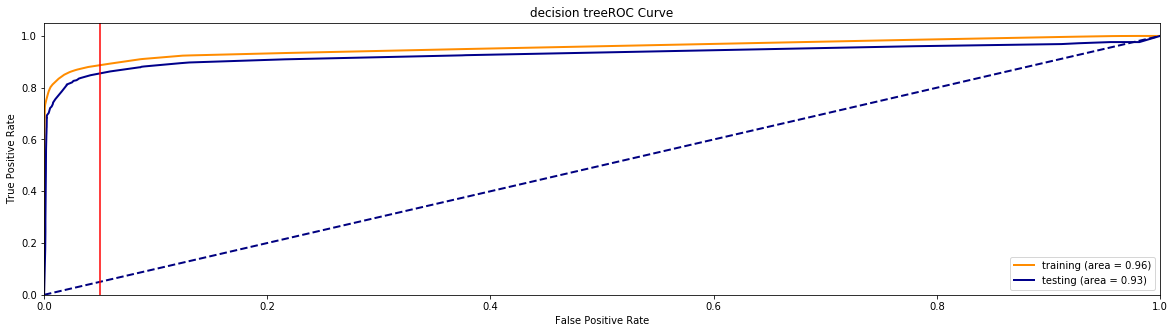

--- random forest ---
Train AUC Score        : 0.930940
Test AUC Score         : 0.905762


--- TEST score thresholds ---
      fpr     tpr  threshold
0 0.01000 0.33000    0.09000
1 0.02000 0.45000    0.08000
2 0.03000 0.52000    0.08000
3 0.04000 0.55000    0.07000
4 0.05000 0.59000    0.07000




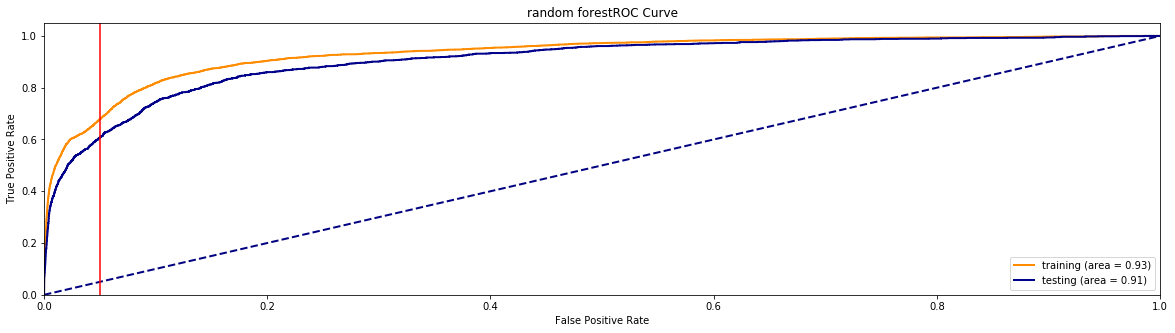

--- extra trees ---
Train AUC Score        : 0.935831
Test AUC Score         : 0.905776


--- TEST score thresholds ---
      fpr     tpr  threshold
0 0.01000 0.18000    0.07000
1 0.02000 0.38000    0.07000
2 0.03000 0.46000    0.06000
3 0.04000 0.51000    0.06000
4 0.05000 0.57000    0.06000




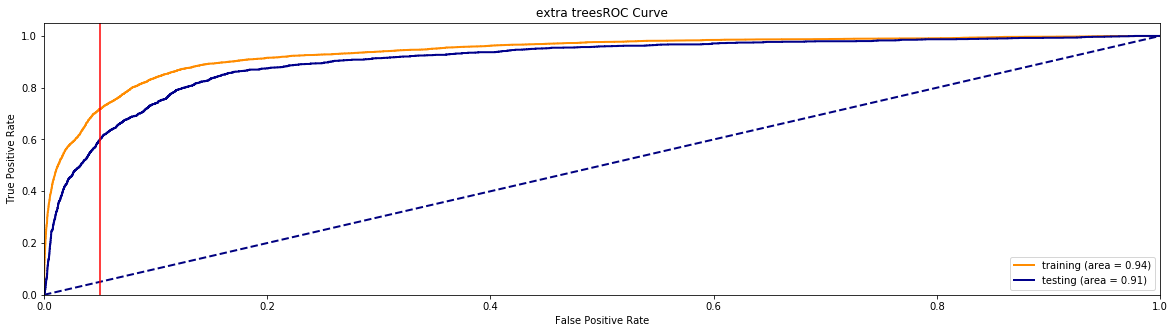

In [34]:
from sklearn.metrics import roc_curve, auc

def model_auc_roc(model, model_name):
    
    #- 1. predict on train and test 
    train_predict_proba = model.predict_proba(train[numeric_features + categorical_features])[:,1]
    test_predict_proba = model.predict_proba(test[numeric_features + categorical_features])[:,1]
    
    #- 2. get fpr, tpr and threshold for train and test 
    train_fpr, train_tpr, train_thr = roc_curve(train[target], train_predict_proba)
    test_fpr, test_tpr, test_thr = roc_curve(test[target], test_predict_proba)
    
    #- 3. get auc and threshold for train and test 
    train_auc = auc( train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)
    
    #- 4. Print performance 
    print ("--- " + model_name + " ---")
    print ("Train AUC Score        : %f" % train_auc)
    print ("Test AUC Score         : %f" % test_auc)
    print ("\n")
   
    #- 5. FPR from 1 - 5% 
    model_stat = pd.concat([
        pd.DataFrame(test_fpr).rename(columns={0:'fpr'}),
        pd.DataFrame(test_tpr).rename(columns={0:'tpr'}),
        pd.DataFrame(test_thr).rename(columns={0:'threshold'})
        ],axis=1
        ).round(decimals=2)
   
    # - just get 1% FPR increments o
    m = model_stat.loc[model_stat.groupby(["fpr"])["threshold"].idxmax()]    
    

    print("--- TEST score thresholds ---")
    print(m.loc[(m['fpr'] > 0.0 ) & (m['fpr'] <= 0.05)].reset_index(drop=True))
    print("\n")
    
    #- 6. plot
    plt.figure(figsize=(20, 5))
    plt.plot(train_fpr, train_tpr, color='darkorange',
             lw=2, label='training (area = %0.2f)' % train_auc)
    plt.plot(test_fpr, test_tpr, color='darkblue',
             lw=2, label='testing (area = %0.2f)' % test_auc)
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.axvline(x= 0.05,  color='r')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title( model_name + 'ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


model_auc_roc(decision_tree, "decision tree")  
model_auc_roc(random_forest, "random forest")
model_auc_roc(extra_trees, "extra trees")